# Verify a Presentation

## Before running this notebook you should have a mobile wallet contained the credential you issued yourself in Part 3. If not run through [Part 2](http://localhost:8888/lab/tree/Part%202%20-%20Writing%20a%20Public%20DID%20to%20the%20Sovrin%20StagingNet.ipynb) and [Part 3](http://localhost:8888/lab/tree/Part%203%20-%20Issue%20Credential.ipynb) of this tutorial.

If unfamiliar with the present-proof protocol it is worth reading through the [aries-rfs](https://github.com/hyperledger/aries-rfcs/tree/master/features/0037-present-proof)


## Note that you do not need to write a public DID to the ledger as a verifier.

## 1. Instatiate Controller for Verifiers's Agent

In [1]:
%autoawait
import time
import asyncio
from termcolor import colored,cprint

from aries_basic_controller.aries_controller import AriesAgentController

WEBHOOK_HOST = "0.0.0.0"
WEBHOOK_PORT = 8052
WEBHOOK_BASE = ""
ADMIN_URL = "http://verifier-agent:8051"

# Based on the aca-py agent you wish to control
agent_controller = AriesAgentController(admin_url=ADMIN_URL)


IPython autoawait is `on`, and set to use `asyncio`


In [2]:
agent_controller.init_webhook_server(webhook_host=WEBHOOK_HOST,
                                     webhook_port=WEBHOOK_PORT,
                                     webhook_base=WEBHOOK_BASE)

## 2. Register Listeners

The handler should get called every time the controller receives a webhook with the topic present_proof, printing out the payload. The agent calls to this webhook every time it receives a present proof protocol message from another agent. 


In [3]:
loop = asyncio.get_event_loop()
loop.create_task(agent_controller.listen_webhooks())

def connections_handler(payload):
    global STATE
    connection_id = payload["connection_id"]
    print("Connection message", payload, connection_id)
    STATE = payload['state']
    if STATE == 'active':
#         print('Connection {0} changed state to active'.format(connection_id))
        print(colored("Connection {0} changed state to active".format(connection_id), "red", attrs=["bold"]))


connection_listener = {
    "handler": connections_handler,
    "topic": "connections"
}

def proof_handler(payload):
    print("Handle present proof")
    print(payload)

proof_listener = {
    "topic": "present_proof",
    "handler": proof_handler
}

agent_controller.register_listeners([connection_listener,proof_listener], defaults=True)



Subscribing too: connections
Subscribing too: present_proof


## 3. Make a connection with the Mobile SSI Wallet you used in [Part 2](http://localhost:8888/lab/tree/Part%202%20-%20Writing%20a%20Public%20DID%20to%20the%20Sovrin%20StagingNet.ipynb)

**You should have a credential stored in here from the previous notebook!**

Please download a mobile SSI wallet such as [Connect.me](https://connect.me/), [Trinsic](https://trinsic.id/trinsic-wallet/) or any other Aries compatible wallet.

## 4. Create a connection invitation to scan with the Mobile SSI Wallet

## 4a. Check for any existing connections

In [4]:
# Check for existing connections
connection = await agent_controller.connections.get_connections()
print("EXISTING CONNECTIONS")
for key, value in connection.items():
    for item in value:
        print('ConnectionID:', item['connection_id'], 'Status:',item['state'])

EXISTING CONNECTIONS


## 4b. Create an Invitation

In [5]:
# Create Invitation
invite = await agent_controller.connections.create_invitation()
connection_id = invite["connection_id"]
print("Connection ID", connection_id)
print("Invitation")
print(invite['invitation_url'])
inviteURL = invite['invitation_url']

Connection message {'invitation_key': 'FhLZC3Y7SZg6medwfefCPXsqN3rNHeu1CEwbx5txc8wU', 'routing_state': 'none', 'connection_id': '817e12d7-b7f7-45cc-bfe5-6467cc27246e', 'accept': 'auto', 'created_at': '2022-12-28 11:08:55.933496Z', 'their_role': 'invitee', 'updated_at': '2022-12-28 11:08:55.933496Z', 'invitation_mode': 'once', 'rfc23_state': 'invitation-sent', 'state': 'invitation'} 817e12d7-b7f7-45cc-bfe5-6467cc27246e
Connection ID 817e12d7-b7f7-45cc-bfe5-6467cc27246e
Invitation
https://338c-140-112-25-44.ngrok.io?c_i=eyJAdHlwZSI6ICJkaWQ6c292OkJ6Q2JzTlloTXJqSGlxWkRUVUFTSGc7c3BlYy9jb25uZWN0aW9ucy8xLjAvaW52aXRhdGlvbiIsICJAaWQiOiAiODg3ZDEzNjYtMGFkMi00OTg0LWI0OTMtYzY0OTMzNjQ4MmRjIiwgInJlY2lwaWVudEtleXMiOiBbIkZoTFpDM1k3U1pnNm1lZHdmZWZDUFhzcU4zck5IZXUxQ0V3Yng1dHhjOHdVIl0sICJzZXJ2aWNlRW5kcG9pbnQiOiAiaHR0cHM6Ly8zMzhjLTE0MC0xMTItMjUtNDQubmdyb2suaW8iLCAibGFiZWwiOiAiVkVSSUZJRVIifQ==


## 4c. Generate QR Code to be scanned with Mobile SSI Wallet

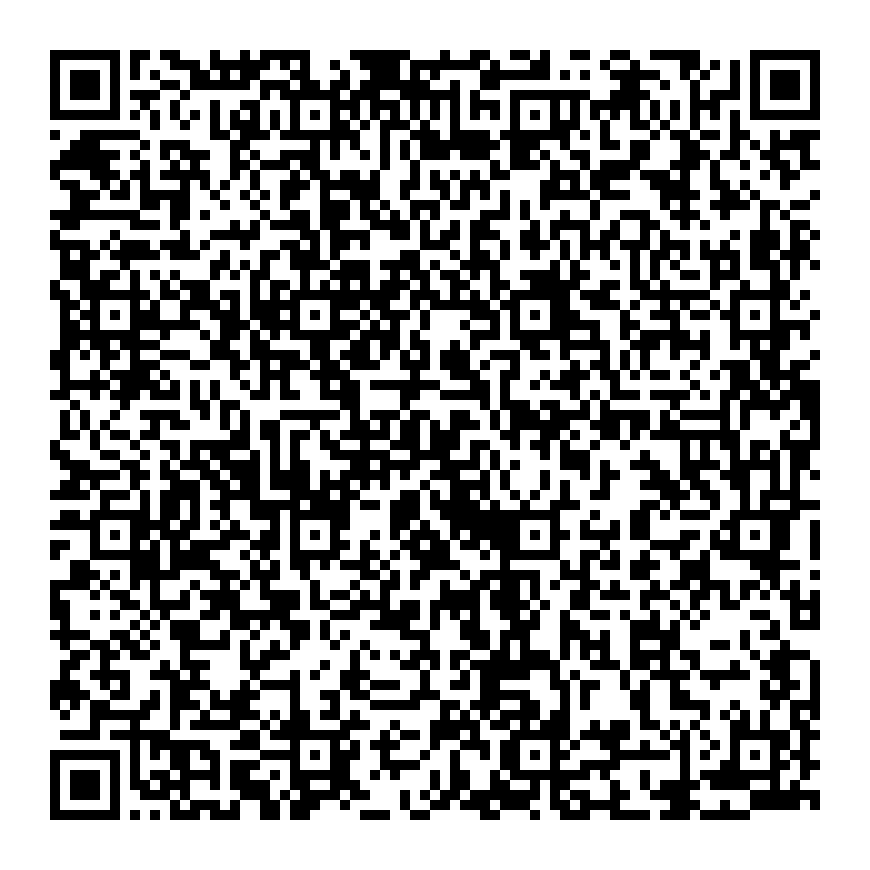

In [6]:
import qrcode
# Link for connection invitation
input_data = inviteURL
# Creating an instance of qrcode
qr = qrcode.QRCode(
        version=1,
        box_size=10,
        border=5)
qr.add_data(input_data)
qr.make(fit=True)
img = qr.make_image(fill='black', back_color='white')
img.save('verifier_agent_invite_QRcode.png')

from IPython.display import Image
Image(width=400, filename='./verifier_agent_invite_QRcode.png')

## 4d. Check if established connection is in active state

In [8]:
import time

# print('Current state for ConnectionId {} is {}'.format(connection_id,STATE))
print(colored("Current state for ConnectionId {} is {}".format(connection_id,STATE), "magenta", attrs=["bold"]))
while STATE != 'active':
#     print('ConnectionId {0} is not in active state yet'.format(connection_id))
    print(colored("ConnectionId {0} is not in active state yet".format(connection_id), "yellow", attrs=["bold"]))
    trust_ping = await agent_controller.messaging.trust_ping(connection_id,'hello!')
#     print('Trust ping send to ConnectionId {0} to activate connection'.format(trust_ping))
    print(colored("Trust ping send to ConnectionId {0} to activate connection".format(trust_ping), "blue", attrs=["bold"]))
    time.sleep(5)
    
# print('ConnectionId: {0} is now active. Continue with notebook'.format(connection_id))
print(colored("ConnectionId: {0} is now active. Continue with notebook".format(connection_id), "green", attrs=["bold"]))


Current state for ConnectionId 817e12d7-b7f7-45cc-bfe5-6467cc27246e is response
ConnectionId 817e12d7-b7f7-45cc-bfe5-6467cc27246e is not in active state yet
Trust ping send to ConnectionId {'thread_id': '2857485f-692c-4d45-b1fc-9fceade57fb9'} to activate connection
ConnectionId 817e12d7-b7f7-45cc-bfe5-6467cc27246e is not in active state yet
Connection message {'my_did': '2iBAHNY9Yj25qgf6dqxT7H', 'invitation_key': 'FhLZC3Y7SZg6medwfefCPXsqN3rNHeu1CEwbx5txc8wU', 'routing_state': 'none', 'connection_id': '817e12d7-b7f7-45cc-bfe5-6467cc27246e', 'accept': 'auto', 'created_at': '2022-12-28 11:08:55.933496Z', 'their_role': 'invitee', 'updated_at': '2022-12-28 11:09:19.861100Z', 'their_label': 'User 的 iPhone', 'invitation_mode': 'once', 'rfc23_state': 'completed', 'state': 'active', 'their_did': 'XLYvrQPTzypwCc2ywgHFvP'} 817e12d7-b7f7-45cc-bfe5-6467cc27246e
Connection 817e12d7-b7f7-45cc-bfe5-6467cc27246e changed state to active
Trust ping send to ConnectionId {'thread_id': 'd2fa4059-ef7f-4fe0-

## 5. Send Proof Request to Identity Holder Mobile Wallet

## 5a. Generate Proof Request

The verifier will request a proof from the identity holder for the following attributes:

    fullname"
    "skill"
    "country" - self-attested
    "age" - as a predicate range proof to determine if the identity holder is older than 21


Note how the verifier has restricted the proof request to only include credentials issued against a specific `schema_id`. 

In our case `schema_id` = EuEtnVakYFyBtGFT1nHYtH:2:SSI PyDentity Tutorial:0.0.1

If you ledgered your own schema in [Part 2](http://127.0.0.1:8888/notebooks/Part%203%20-%20Issuer.ipynb) and didn't use the pre-ledgered schema then please copy the new schema_id into the `schemaid` variable in the cell below.

TODO: Add information around predicates

In [11]:
schema_id = '55gBgeJZd758dgk9Hb8e44:2:SSI PyDentity Tutorial:0.0.1'

print("Request proof of Fullname and Age range from Identity Holder")
#Set some variables

revocation = False
SELF_ATTESTED = True
exchange_tracing = False

#Enable this to ask for attributes to identity a user
#TODO - change restriction to schemaId or credentialId

req_attrs = [
    {"name": "fullname", "restrictions": [{"schema_id": schema_id}]},
    {"name": "skill", "restrictions": [{"schema_id": schema_id}]},
]

if revocation:
    req_attrs.append(
        {
            "name": "skill",
            "restrictions": [{"schema_id": schema_id}],
            "non_revoked": {"to": int(time.time() - 1)},
        },
    )

if SELF_ATTESTED:
    # test self-attested claims
    req_attrs.append({"name": "country"},)

#Set predicates for Zero Knowledge Proofs
req_preds = [
    # test zero-knowledge proofs
    {
        "name": "age",
        "p_type": ">=",
        "p_value": 21,
        "restrictions": [{"schema_id": schema_id}],
    }
]

indy_proof_request = {
    "name": "Proof of Completion of PyDentity SSI Tutorial",
    "version": "1.0",
    "requested_attributes": {
        f"0_{req_attr['name']}_uuid":
        req_attr for req_attr in req_attrs
    },
    "requested_predicates": {
        f"0_{req_pred['name']}_GE_uuid":
        req_pred for req_pred in req_preds
    },
}

if revocation:
    indy_proof_request["non_revoked"] = {"to": int(time.time())}

#proof_request = indy_proof_request
exchange_tracing_id = exchange_tracing
proof_request_web_request = {
    "connection_id": connection_id,
    "proof_request": indy_proof_request,
    "trace": exchange_tracing,
}

Request proof of Fullname and Age range from Identity Holder


### 5b. Send the proof request to Identity Holder

Identity Holder is identified through the connection_id

In [12]:
response = await agent_controller.proofs.send_request(proof_request_web_request)
print(response)
presentation_exchange_id = response['presentation_exchange_id']
print("\n")
print(presentation_exchange_id)


{'thread_id': 'bc41bf03-b9db-43c5-897a-58b7735e490a', 'presentation_request_dict': {'@type': 'did:sov:BzCbsNYhMrjHiqZDTUASHg;spec/present-proof/1.0/request-presentation', '@id': 'bc41bf03-b9db-43c5-897a-58b7735e490a', 'request_presentations~attach': [{'@id': 'libindy-request-presentation-0', 'mime-type': 'application/json', 'data': {'base64': 'eyJuYW1lIjogIlByb29mIG9mIENvbXBsZXRpb24gb2YgUHlEZW50aXR5IFNTSSBUdXRvcmlhbCIsICJ2ZXJzaW9uIjogIjEuMCIsICJyZXF1ZXN0ZWRfYXR0cmlidXRlcyI6IHsiMF9mdWxsbmFtZV91dWlkIjogeyJuYW1lIjogImZ1bGxuYW1lIiwgInJlc3RyaWN0aW9ucyI6IFt7InNjaGVtYV9pZCI6ICI1NWdCZ2VKWmQ3NThkZ2s5SGI4ZTQ0OjI6U1NJIFB5RGVudGl0eSBUdXRvcmlhbDowLjAuMSJ9XX0sICIwX3NraWxsX3V1aWQiOiB7Im5hbWUiOiAic2tpbGwiLCAicmVzdHJpY3Rpb25zIjogW3sic2NoZW1hX2lkIjogIjU1Z0JnZUpaZDc1OGRnazlIYjhlNDQ6MjpTU0kgUHlEZW50aXR5IFR1dG9yaWFsOjAuMC4xIn1dfSwgIjBfY291bnRyeV91dWlkIjogeyJuYW1lIjogImNvdW50cnkifX0sICJyZXF1ZXN0ZWRfcHJlZGljYXRlcyI6IHsiMF9hZ2VfR0VfdXVpZCI6IHsibmFtZSI6ICJhZ2UiLCAicF90eXBlIjogIj49IiwgInBfdmFsdWUiOiAyMSwgInJlc3

## 6. Verify Proof Presentation

This is checking the signatures on the credentials presented against the credential schema and definition id stored and resolvable on the ledger. It is a bit of a big complicated object, so we show the common pattern for breaking it down, checking it's verified and accessing the data that has been presented.

In [14]:
verify = await agent_controller.proofs.verify_presentation(presentation_exchange_id)
print(verify)

Handle present proof
{'thread_id': 'bc41bf03-b9db-43c5-897a-58b7735e490a', 'presentation_request_dict': {'@type': 'did:sov:BzCbsNYhMrjHiqZDTUASHg;spec/present-proof/1.0/request-presentation', '@id': 'bc41bf03-b9db-43c5-897a-58b7735e490a', 'request_presentations~attach': [{'@id': 'libindy-request-presentation-0', 'mime-type': 'application/json', 'data': {'base64': 'eyJuYW1lIjogIlByb29mIG9mIENvbXBsZXRpb24gb2YgUHlEZW50aXR5IFNTSSBUdXRvcmlhbCIsICJ2ZXJzaW9uIjogIjEuMCIsICJyZXF1ZXN0ZWRfYXR0cmlidXRlcyI6IHsiMF9mdWxsbmFtZV91dWlkIjogeyJuYW1lIjogImZ1bGxuYW1lIiwgInJlc3RyaWN0aW9ucyI6IFt7InNjaGVtYV9pZCI6ICI1NWdCZ2VKWmQ3NThkZ2s5SGI4ZTQ0OjI6U1NJIFB5RGVudGl0eSBUdXRvcmlhbDowLjAuMSJ9XX0sICIwX3NraWxsX3V1aWQiOiB7Im5hbWUiOiAic2tpbGwiLCAicmVzdHJpY3Rpb25zIjogW3sic2NoZW1hX2lkIjogIjU1Z0JnZUpaZDc1OGRnazlIYjhlNDQ6MjpTU0kgUHlEZW50aXR5IFR1dG9yaWFsOjAuMC4xIn1dfSwgIjBfY291bnRyeV91dWlkIjogeyJuYW1lIjogImNvdW50cnkifX0sICJyZXF1ZXN0ZWRfcHJlZGljYXRlcyI6IHsiMF9hZ2VfR0VfdXVpZCI6IHsibmFtZSI6ICJhZ2UiLCAicF90eXBlIjogIj49IiwgInBfd

### Verifying the State

Once verified through the agent framework api, the state should be 'verified', otherwise the presentation is invalid.

In [15]:
print(verify['state'])
print(verify['state'] == 'verified')

verified
True


### Accessing the Revealed Attributes

In [16]:
# print(verify['presentation'])
# print(verify['presentation']['requested_proof'])

for (name, val) in verify['presentation']['requested_proof']['revealed_attrs'].items():
    ## This is the actual data that you want. It's a little hidden
    print(val['raw'])


Leo Lu
PyDentity SSI Ninja


### Accessing self-attested attributes

In [17]:
for (name, val) in verify['presentation']['requested_proof']['self_attested_attrs'].items():
    print(name)
    ## Slightly different for self attested attrs
    print(val)

0_country_uuid
Taiwan


## End of Tutorial

Be sure to terminate the controller so you can run another tutorial.

In [ ]:
response = await agent_controller.terminate()
print(response)

## Well done on completing the PyDentity SSI training series!